In [1]:
#data manipulation
import numpy as np
import pandas as pd

from datetime import datetime
import itertools

#data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

import acquire
import prepare_2

<class 'dict'>

The API accepts GET requests for all endpoints, where endpoints are prefixed
with

    /api/{version}

Where version is "v1"

Valid endpoints:

- /stores[/{store_id}]
- /items[/{item_id}]
- /sales[/{sale_id}]

All endpoints accept a `page` parameter that can be used to navigate through
the results.

max_page: 3
next_page: /api/v1/items?page=2
max_page: 3
next_page: /api/v1/items?page=3
max_page: 3
next_page: None
max_page: 1
next_page: None
max_page: 183
next_page: /api/v1/sales?page=2


## Exploration Exercises

Remember to document your thoughts and any takeaways as you work through visualizations!

Using your store items data you prepped in lesson 2 exercises:

1. Split your data into train and test using the sklearn.model_selection.TimeSeriesSplit method.

2. Validate your splits by plotting X_train and y_train.

3. Plot the weekly average & the 7-day moving average. Compare the 2 plots.

4. Plot the daily difference. Observe whether usage seems to vary drastically from day to day or has more of a smooth transition.

5. Plot a time series decomposition.

6. Create a lag plot (day over day).

7. Run a lag correlation.

Using your OPS data you prepped in lesson 2 exercises:

1. Split your data into train and test using the percent cutoff method.

2. Validate your splits by plotting X_train and y_train.

3. Plot the weekly average & the 7-day moving average. Compare the 2 plots.

4. Group the electricity consumption time series by month of year, to explore annual seasonality.

5. Plot the daily difference. Observe whether usage seems to vary drastically from day to day or has more of a smooth transition.

6. Plot a time series decomposition. Takeaways?

7. Create a lag plot (day over day).

8. Run a lag correlation.

If time:

For each store I want to see how many items were sold over a period of time, for each item. Find a way to chart this. Hints: Subplots for the piece with the fewest distinct values (like store), x = time, y = count, color = item. If you have too many distinct items, you may need to plot the top n, while aggregating the others into an 'other' bucket.

### Acquire:

In [2]:
df = acquire.get_all_the_data()

In [3]:
df = prepare_2.prep_store_data(df)

In [4]:
df.head()

,item_id,sale_amount,sale_id,store_id,item_brand,item_name,item_price,item_upc12,item_upc14,store_address,store_city,store_state,store_zipcode,month,weekend,sales_total
sale_date,,,,,,,,,,,,,,,,
2013-01-01 00:00:00+00:00,1,13.0,1,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253,01-Jan,2-Tue,10.92
2013-01-01 00:00:00+00:00,17,26.0,295813,3,Ducal,Ducal Refried Red Beans,1.16,88313590791,88313590791,2118 Fredericksburg Rdj,San Antonio,TX,78201,01-Jan,2-Tue,30.16
2013-01-01 00:00:00+00:00,7,32.0,125995,10,Twinings Of London,Twinings Of London Classics Lady Grey Tea - 20 Ct,9.64,70177154004,70177154004,8503 NW Military Hwy,San Antonio,TX,78231,01-Jan,2-Tue,308.48
2013-01-01 00:00:00+00:00,18,45.0,314073,3,Scotch,Scotch Removable Clear Mounting Squares - 35 Ct,4.39,21200725340,21200725340,2118 Fredericksburg Rdj,San Antonio,TX,78201,01-Jan,2-Tue,197.55
2013-01-01 00:00:00+00:00,19,34.0,332333,3,Careone,Careone Family Comb Set - 8 Ct,0.74,41520035646,41520035646,2118 Fredericksburg Rdj,San Antonio,TX,78201,01-Jan,2-Tue,25.16


In [5]:
target_vars = ['sale_amount', 'sales_total']
df = df.resample('D')[target_vars].sum()

In [6]:
df.head()

,sale_amount,sales_total
sale_date,,
2013-01-01 00:00:00+00:00,13696.0,73844.01
2013-01-02 00:00:00+00:00,13678.0,73570.58
2013-01-03 00:00:00+00:00,14488.0,78169.48
2013-01-04 00:00:00+00:00,15677.0,84467.73
2013-01-05 00:00:00+00:00,16237.0,87621.85


Store Item Sales

Q1

Split your data into train and test using the sklearn.model_selection.TimeSeriesSplit method

In [7]:
# reset index to be row number
df2 = df.reset_index()

# create X and y
X = df2.sale_date
y = df2.sale_amount

# create object, with 5 splits
tss = TimeSeriesSplit(n_splits=5, max_train_size=None)

# fit (get index values)
# transform into X_train, X_test, y_train, y_test
for train_index, test_index in tss.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

Q2

Validate your splits by plotting X_train and y_train.

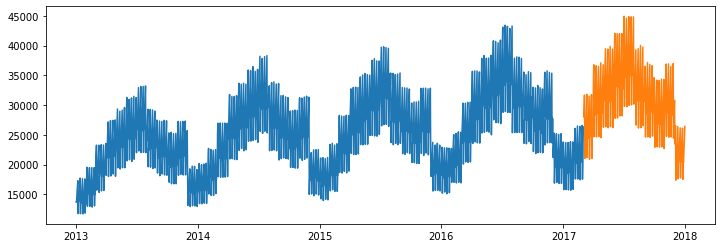

In [8]:
plt.figure(figsize = (12,4))
plt.plot(X_train, y_train)
plt.plot(X_test, y_test)
plt.show()

Q3

Plot the weekly average & the 7-day moving average. Compare the 2 plots.

In [9]:
data = {'sale_date': X_train, 'sale_amount': y_train}
train = pd.DataFrame(data)
train = train.groupby(['sale_date']).sum()

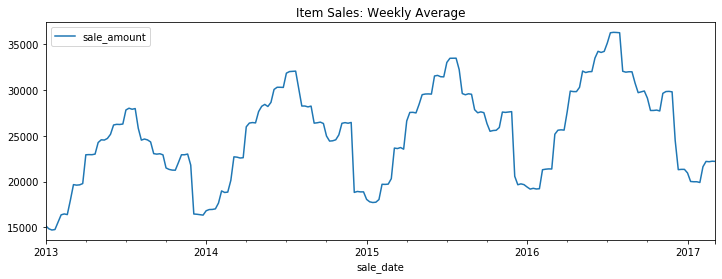

In [10]:
train_W = train.resample('W').mean()
ax = train_W.plot(figsize = (12,4))
ax.set_title('Item Sales: Weekly Average')
plt.show()

<Figure size 864x288 with 0 Axes>

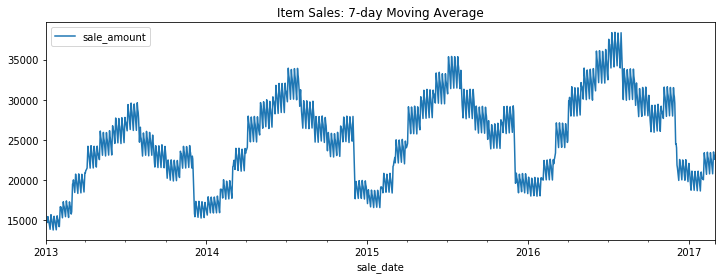

In [11]:
plt.figure(figsize = (12,4))
ax = train.rolling(5).mean().plot(figsize=(12, 4))
ax.set_title('Item Sales: 7-day Moving Average')
plt.show()

Q4

Plot the daily difference. Observe whether usage seems to vary drastically from day to day or has more of a smooth transition.

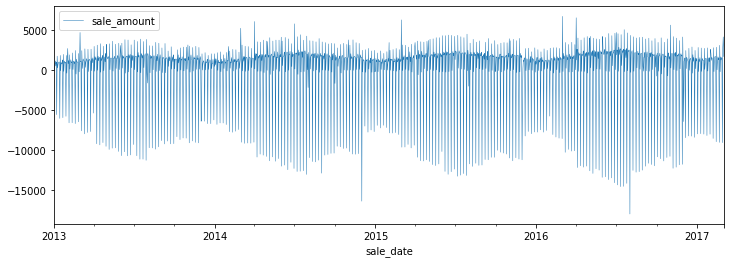

In [12]:
train.diff(periods=1).plot(figsize=(12, 4), linewidth=0.5)

Q5

Plot a time series decomposition.

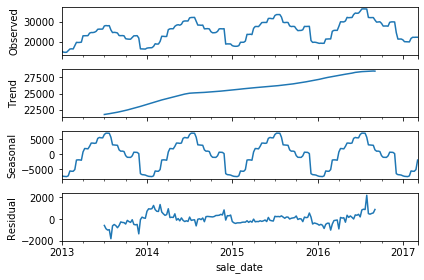

In [13]:
decomposition = sm.tsa.seasonal_decompose(train.resample('W').mean(), model='additive')

fig = decomposition.plot()
plt.show()

Q6

Create a lag plot (day over day).

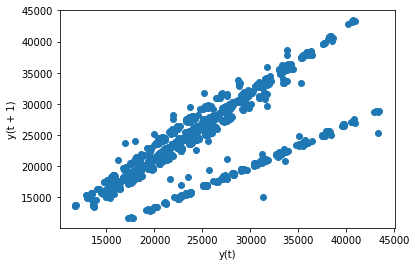

In [14]:
pd.plotting.lag_plot(train.resample('D').mean(), lag=1)

Q7

Run a lag correlation.

In [15]:
df_corr = pd.concat([train.shift(1), train], axis=1)
df_corr.columns = ['t-1','t+1']
result = df_corr.corr()
print(result)

          t-1       t+1
t-1  1.000000  0.749048
t+1  0.749048  1.000000


Using your OPS data you prepped in lesson 2 exercises:

Q1

Split your data into train and test using the percent cutoff method.

In [16]:
ops = acquire.get_opsd_data()

In [17]:
ops.head()

,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.184,NaN,NaN,NaN
1,2006-01-02,1380.521,NaN,NaN,NaN
2,2006-01-03,1442.533,NaN,NaN,NaN
3,2006-01-04,1457.217,NaN,NaN,NaN
4,2006-01-05,1477.131,NaN,NaN,NaN


In [18]:
# to datetime
ops['date'] = pd.to_datetime(ops['Date'])
ops = ops.set_index('date').resample('D').sum()

# Set the train size to be 66% of total size of dataframe (# of rows).   
# Compute how many rows that is.  
train_size = int(len(ops) * 0.66)

# Select our data up to the index representing the 66th percentile as our 'train' sample.  
# Select our data from the 66th percentile through the end of the dataframe as our 'test' sample.  

train, test = ops[0:train_size], ops[train_size:len(ops)]
print('Observations: %d' % (len(ops)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 4383
Training Observations: 2892
Testing Observations: 1491


2. Validate your splits by plotting X_train and y_train.


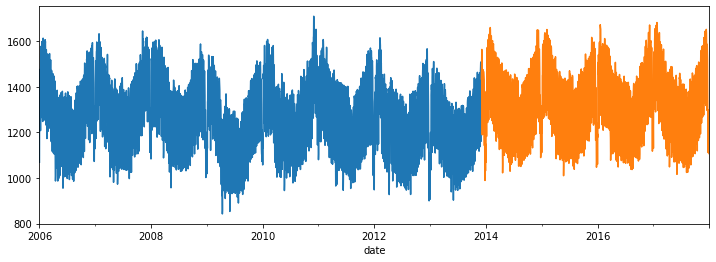

In [19]:
train.Consumption.plot(figsize=(12,4))
test.Consumption.plot(figsize=(12,4))
plt.show()

3. Plot the weekly average & the 7-day moving average. Compare the 2 plots.

4. Group the electricity consumption time series by month of year, to explore annual seasonality.

5. Plot the daily difference. Observe whether usage seems to vary drastically from day to day or has more of a smooth transition.

6. Plot a time series decomposition. Takeaways?